In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [3]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
stayed = df[df['Exited']==0]
exited = df[df['Exited']==1]

In [7]:
print(stayed.shape)
print(exited.shape)

(7963, 14)
(2037, 14)


# EDA

In [8]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

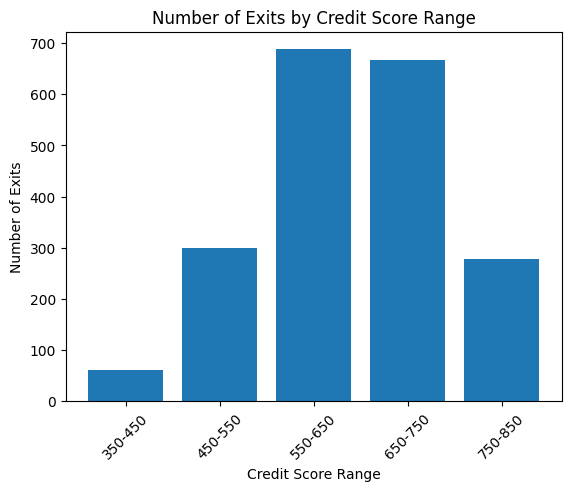

In [9]:
score_ranges = [(350, 450), (450, 550), (550, 650), (650, 750), (750, 850)]

bins = [score_range[0] for score_range in score_ranges] + [score_ranges[-1][-1]]

labels = [f'{score_range[0]}-{score_range[1]}' for score_range in score_ranges]

df['CreditScoreRange'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

exit_counts = df.groupby('CreditScoreRange')['Exited'].sum().reset_index()

plt.bar(exit_counts['CreditScoreRange'], exit_counts['Exited'])
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Exits')
plt.title('Number of Exits by Credit Score Range')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

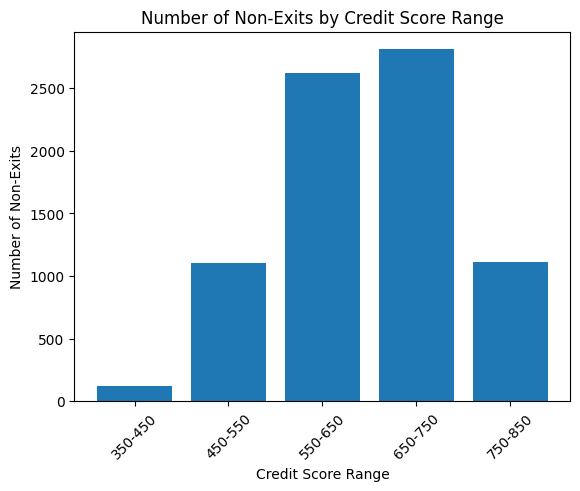

In [10]:
non_exit_counts = df[df['Exited'] == 0].groupby('CreditScoreRange')['Exited'].count().reset_index()

plt.bar(non_exit_counts['CreditScoreRange'], non_exit_counts['Exited'])
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Non-Exits')
plt.title('Number of Non-Exits by Credit Score Range')
plt.xticks(rotation=45)
plt.show()

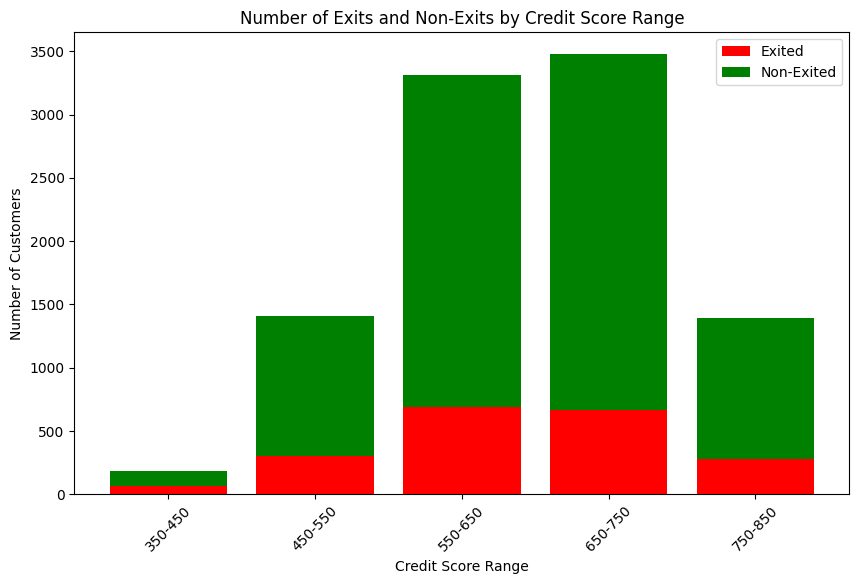

In [11]:
combined_counts = df.groupby('CreditScoreRange')['Exited'].agg(['sum', lambda x: (x == 0).sum()]).reset_index()
combined_counts.columns = ['CreditScoreRange', 'Exited', 'NonExited']

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'Exited' bars
ax.bar(combined_counts['CreditScoreRange'], combined_counts['Exited'], label='Exited', color='red')

# Plot 'NonExited' bars on top of 'Exited' bars
ax.bar(combined_counts['CreditScoreRange'], combined_counts['NonExited'], label='Non-Exited', bottom=combined_counts['Exited'], color='green')

ax.set_xlabel('Credit Score Range')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Exits and Non-Exits by Credit Score Range')
ax.legend()
plt.xticks(rotation=45)

plt.show()


It is evident that the number of exits and non-exits follow the same pattern.
It can be interpreted that the exits are not entirely dependent on credit score values

In [12]:
unique_values = df['Geography'].unique()
print(unique_values)

['France' 'Spain' 'Germany']


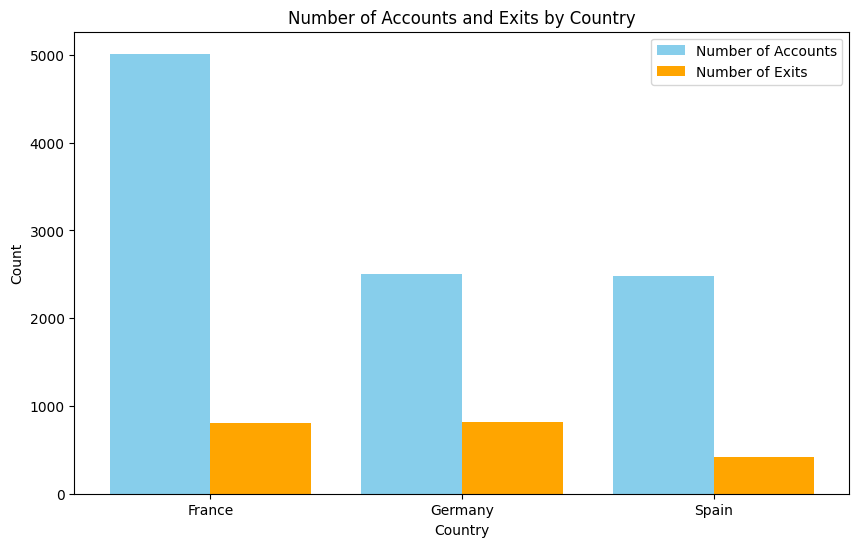

In [13]:
account_counts = df['Geography'].value_counts().reset_index()
account_counts.columns = ['Country', 'Number of Accounts']

# Number of exits by country
exit_counts = df.groupby('Geography')['Exited'].sum().reset_index()
exit_counts.columns = ['Country', 'Number of Exits']

# Merge the two DataFrames on 'Country'
combined_counts = pd.merge(account_counts, exit_counts, on='Country')

# Plotting the histogram with stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
bar_positions = range(len(combined_counts))

# Plot 'Number of Accounts'
ax.bar(bar_positions, combined_counts['Number of Accounts'], width=bar_width, label='Number of Accounts', color='skyblue')

# Plot 'Number of Exits' on top of 'Number of Accounts'
ax.bar([pos + bar_width for pos in bar_positions], combined_counts['Number of Exits'], width=bar_width, label='Number of Exits', color='orange')

ax.set_xlabel('Country')
ax.set_ylabel('Count')
ax.set_title('Number of Accounts and Exits by Country')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(combined_counts['Country'])
ax.legend()

plt.show()

It can be interpreted that account holders from Germany are contributing more to churning.

This is because, even though there are comparatively less account holders from Germany, the number of people no longer continuing the bank services is comparatively higher.

In [14]:
gender_count = df['Gender'].value_counts().reset_index()
gender_count

,index,Gender
0,Male,5457
1,Female,4543


In [15]:
count_by_gender = df.groupby('Gender')['Exited'].sum().reset_index()
print(count_by_gender)

   Gender  Exited
0  Female    1139
1    Male     898


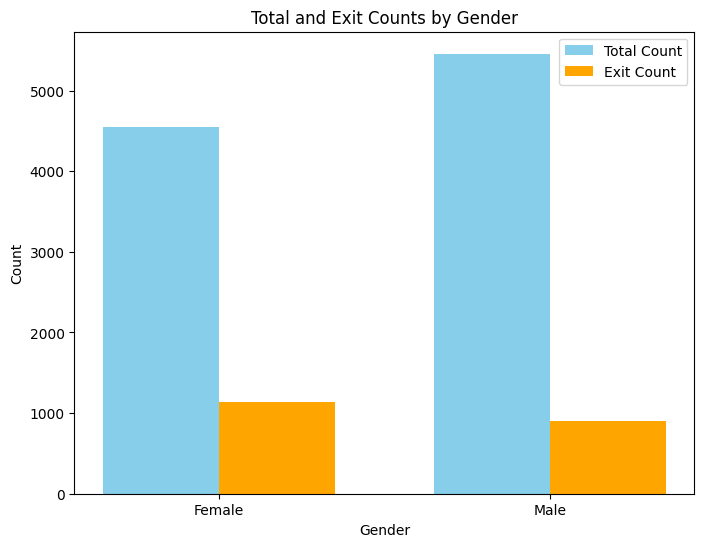

In [16]:
# Group by 'Gender' and calculate total count and exit count
gender_counts = df.groupby('Gender')['Exited'].agg(['count', 'sum']).reset_index()
gender_counts.columns = ['Gender', 'TotalCount', 'ExitCount']

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
bar_positions = range(len(gender_counts))

# Plot total counts
ax.bar(bar_positions, gender_counts['TotalCount'], width=bar_width, label='Total Count', color='skyblue')

# Plot exit counts
ax.bar([pos + bar_width for pos in bar_positions], gender_counts['ExitCount'], width=bar_width, label='Exit Count', color='orange')

ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Total and Exit Counts by Gender')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(gender_counts['Gender'])
ax.legend()

plt.show()

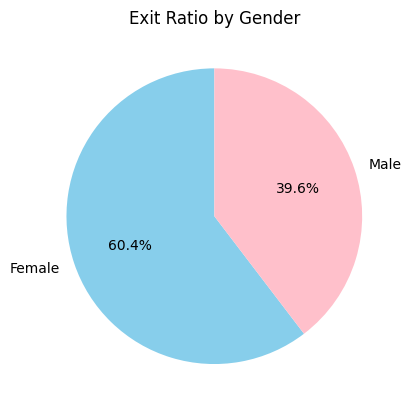

In [17]:
gender_counts['ExitRatio'] = gender_counts['ExitCount'] / gender_counts['TotalCount']

# Plotting the pie chart
labels = gender_counts['Gender']
sizes = gender_counts['ExitRatio']
colors = ['skyblue', 'pink']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Exit Ratio by Gender')

plt.show()

It is observed that ratio of female exits is more than ratio of male exits.

In [18]:
df['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

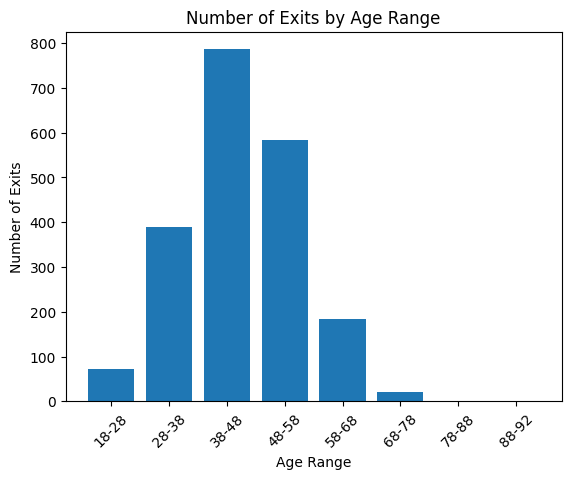

In [19]:
age_ranges = [(18, 28), (28, 38), (38, 48), (48, 58), (58, 68), (68, 78), (78, 88), (88, 92)]

bins = [age_range[0] for age_range in age_ranges] + [age_ranges[-1][-1]]

labels = [f'{age_range[0]}-{age_range[1]}' for age_range in age_ranges]

df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

exit_counts = df.groupby('AgeRange')['Exited'].sum().reset_index()

plt.bar(exit_counts['AgeRange'], exit_counts['Exited'])
plt.xlabel('Age Range')
plt.ylabel('Number of Exits')
plt.title('Number of Exits by Age Range')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

It is observed that account holders of age between 38 to 48 exit the bank service most, followed by the accountholders of age 48-58 and 28-38 respectively

In [20]:
df['Tenure'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

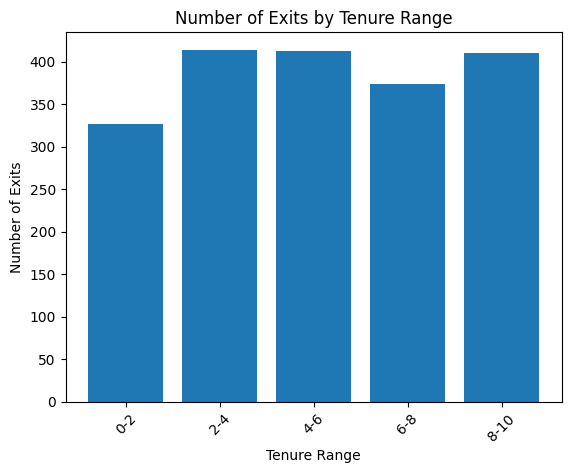

In [21]:
tenure_ranges = [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10)]

bins = [tenure_range[0] for tenure_range in tenure_ranges] + [tenure_ranges[-1][-1]]

labels = [f'{tenure_range[0]}-{tenure_range[1]}' for tenure_range in tenure_ranges]

df['TenureRange'] = pd.cut(df['Tenure'], bins=bins, labels=labels, right=False)

exit_counts = df.groupby('TenureRange')['Exited'].sum().reset_index()

plt.bar(exit_counts['TenureRange'], exit_counts['Exited'])
plt.xlabel('Tenure Range')
plt.ylabel('Number of Exits')
plt.title('Number of Exits by Tenure Range')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

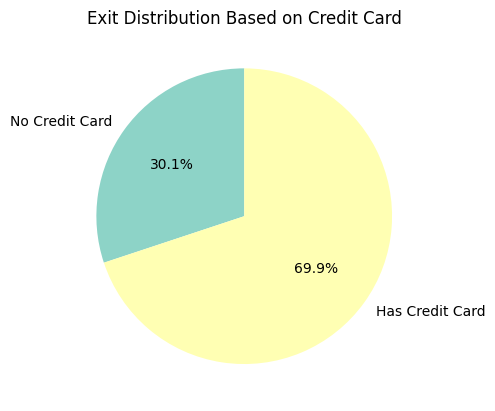

In [22]:
exit_counts = df.groupby('HasCrCard')['Exited'].sum().reset_index()

# Plotting the pie chart
labels = ['No Credit Card', 'Has Credit Card']
sizes = exit_counts['Exited']
colors = plt.cm.Set3.colors  # Using a colormap for colors

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Exit Distribution Based on Credit Card')

plt.show()

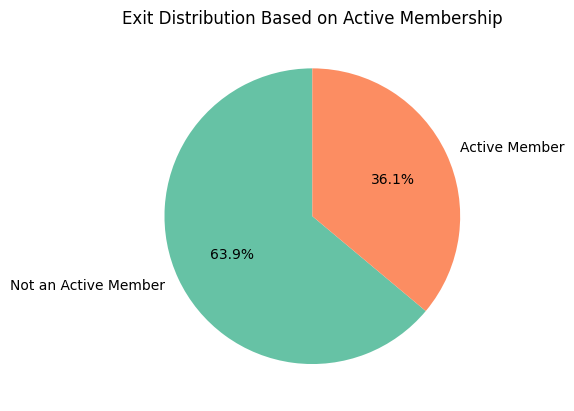

In [23]:
exit_counts = df.groupby('IsActiveMember')['Exited'].sum().reset_index()

# Plotting the pie chart
labels = ['Not an Active Member', 'Active Member']
sizes = exit_counts['Exited']
colors = plt.cm.Set2.colors  # Using a colormap for colors

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Exit Distribution Based on Active Membership')

plt.show()

In [24]:
df['NumOfProducts'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64

In [25]:
exit_count = df.groupby('NumOfProducts')['Exited'].sum().reset_index()
exit_count

,NumOfProducts,Exited
0,1,1409
1,2,348
2,3,220
3,4,60


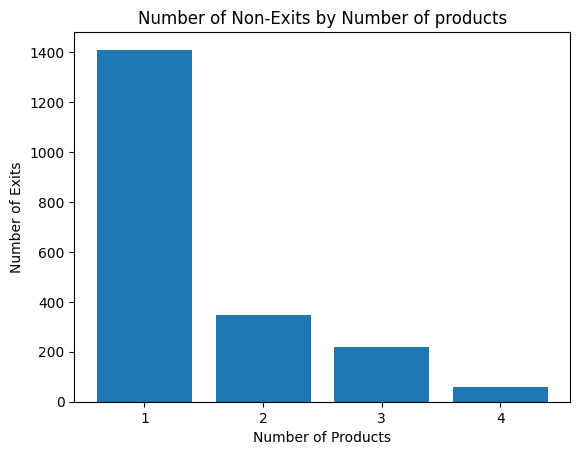

In [26]:
plt.bar(exit_count['NumOfProducts'], exit_count['Exited'])
plt.xlabel('Number of Products')
plt.ylabel('Number of Exits')
plt.title('Number of Non-Exits by Number of products')
plt.xticks(exit_count['NumOfProducts'])
plt.show()

In [27]:
df['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

In [28]:
df['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

<ipython-input-29-21ef40352d9d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


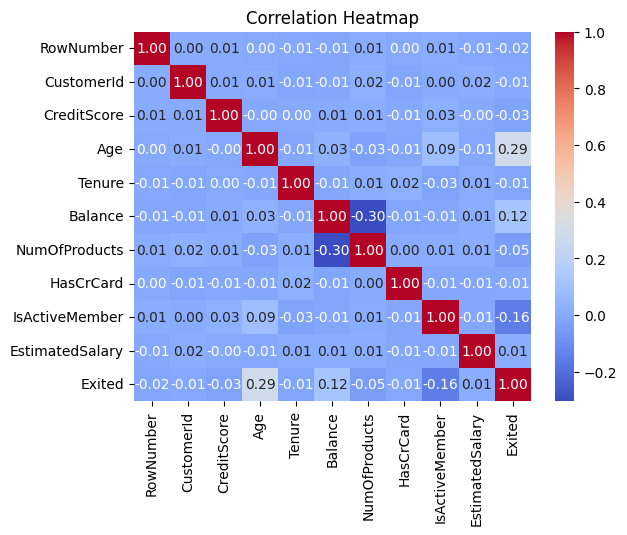

In [29]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [30]:
# RowNumber          0
# CustomerId         0
# Surname            0
# CreditScore        0
# Geography          0
# Gender             0
# Age                0
# Tenure             0
# Balance            0
# NumOfProducts      0
# HasCrCard          0
# IsActiveMember     0
# EstimatedSalary    0
# Exited

In [31]:
df.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
CreditScoreRange    233
AgeRange              2
TenureRange         490
dtype: int64

In [32]:
# scaler = StandardScaler()
# df['Standardized_Balance'] = scaler.fit_transform(df[['Balance']])
# df['Standardized_EstimatedSalary'] = scaler.fit_transform(df[['EstimatedSalary']])

In [33]:
# df = df.drop(['RowNumber', 'Surname','Balance','EstimatedSalary', 'CreditScoreRange', 'AgeRange', 'TenureRange'], axis=1)
df = df.drop(['RowNumber', 'Surname', 'CreditScoreRange', 'AgeRange', 'TenureRange'], axis=1)

In [34]:
df = pd.get_dummies(df, columns=['Geography'], prefix='Country')

In [35]:
df.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain
0,15634602,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,15647311,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,15619304,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,15701354,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,15737888,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [36]:
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})

In [37]:
df.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country_France,Country_Germany,Country_Spain
0,15634602,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,15647311,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,15619304,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,15701354,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,15737888,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


# Model Training

In [38]:
X = df.drop(columns='Exited', axis=1)
y = df['Exited']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [41]:
svm = SVC(kernel='rbf', C=1.0)
logreg_model = LogisticRegression()
gnb_model = GaussianNB()
bnb_model = BernoulliNB()
mnb_model = MultinomialNB()

In [42]:
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

# Evaluate the SVM on the test set
report = classification_report(y_test, y_pred)

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1607
           1       0.76      0.38      0.51       393

    accuracy                           0.85      2000
   macro avg       0.81      0.68      0.71      2000
weighted avg       0.85      0.85      0.83      2000



In [44]:
overall_report = {'SVM': [0.86, 0.76, 0.97, 0.38, 0.92, 0.51, 0.85]}

In [45]:
logreg_model.fit(X_train_std, y_train)

y_pred_logreg = logreg_model.predict(X_test_std)

report_logreg = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report:")
print(report_logreg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



In [46]:
overall_report['Log-Reg'] = [0.83, 0.55, 0.96, 0.20, 0.89, 0.29, 0.81]

In [47]:
gnb_model.fit(X_train_std, y_train)

y_pred_gnb = gnb_model.predict(X_test_std)

report_gnb = classification_report(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Classification Report:")
print(report_gnb)

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1607
           1       0.59      0.39      0.47       393

    accuracy                           0.83      2000
   macro avg       0.73      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000



In [48]:
overall_report['GNB'] = [0.86, 0.59, 0.93, 0.39, 0.90, 0.47, 0.83]

In [49]:
bnb_model.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred_bnb = bnb_model.predict(X_test_std)

report_bnb = classification_report(y_test, y_pred_bnb)
print("Bernoulli Naive Bayes Classification Report:")
print(report_bnb)

Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1607
           1       0.53      0.31      0.39       393

    accuracy                           0.81      2000
   macro avg       0.69      0.62      0.64      2000
weighted avg       0.78      0.81      0.79      2000



In [50]:
overall_report['BNB'] = [0.85, 0.53, 0.93, 0.31, 0.89, 0.39, 0.81]

**Results after data handling**

**Using SMOTE**

In [51]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [52]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_res)
X_test_std = scaler.transform(X_test)

In [53]:
svm.fit(X_train_std, y_train_res)
y_pred = svm.predict(X_test_std)

report = classification_report(y_test, y_pred)
print("svm Classification Report:")
print(report)

svm Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1607
           1       0.59      0.61      0.60       393

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000



In [54]:
overall_report['SVM with SMOTE'] = [0.90, 0.59, 0.90, 0.61, 0.90, 0.60, 0.84]

In [55]:
 logreg_model.fit(X_train_std, y_train_res)

y_pred_logreg = logreg_model.predict(X_test_std)

report_logreg = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report:")
print(report_logreg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1607
           1       0.45      0.48      0.47       393

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.67      2000
weighted avg       0.79      0.78      0.79      2000



In [56]:
overall_report['Log-Reg with SMOTE'] = [0.87, 0.45, 0.86, 0.48, 0.87, 0.47, 0.78]

In [57]:
gnb_model.fit(X_train_std, y_train_res)

y_pred_gnb = gnb_model.predict(X_test_std)

report_gnb = classification_report(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Classification Report:")
print(report_gnb)

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1607
           1       0.39      0.55      0.46       393

    accuracy                           0.74      2000
   macro avg       0.63      0.67      0.64      2000
weighted avg       0.78      0.74      0.76      2000



In [58]:
overall_report['GNB with SMOTE'] = [0.88, 0.39, 0.79, 0.55, 0.83, 0.46, 0.74]

In [59]:
bnb_model.fit(X_train_std, y_train_res)

# Make predictions on the test set
y_pred_bnb = bnb_model.predict(X_test_std)

report_bnb = classification_report(y_test, y_pred_bnb)
print("Bernoulli Naive Bayes Classification Report:")
print(report_bnb)

Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1607
           1       0.43      0.58      0.49       393

    accuracy                           0.77      2000
   macro avg       0.66      0.70      0.67      2000
weighted avg       0.80      0.77      0.78      2000



In [60]:
overall_report['BNB with SMOTE'] = [0.89, 0.43, 0.81, 0.58, 0.85, 0.49, 0.77]

**Using Near Miss Algorithm**

In [61]:
nr = NearMiss()
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())

In [62]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_miss)
X_test_std = scaler.transform(X_test)

In [63]:
svm.fit(X_train_std, y_train_miss)
y_pred = svm.predict(X_test_std)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.56      0.71      1607
           1       0.33      0.87      0.48       393

    accuracy                           0.62      2000
   macro avg       0.64      0.72      0.59      2000
weighted avg       0.83      0.62      0.66      2000



In [64]:
overall_report['SVM with NM'] = [0.95, 0.33, 0.56, 0.87, 0.71, 0.48, 0.62]

In [65]:
logreg_model.fit(X_train_std, y_train_miss)

y_pred_logreg = logreg_model.predict(X_test_std)

report_logreg = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report:")
print(report_logreg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.66      1607
           1       0.29      0.80      0.43       393

    accuracy                           0.57      2000
   macro avg       0.60      0.66      0.54      2000
weighted avg       0.79      0.57      0.62      2000



In [66]:
overall_report['Log-Reg with NM'] = [0.92, 0.29, 0.52, 0.80, 0.66, 0.43, 0.57]

In [67]:
gnb_model.fit(X_train_std, y_train_miss)

y_pred_gnb = gnb_model.predict(X_test_std)

report_gnb = classification_report(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Classification Report:")
print(report_gnb)

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      1607
           1       0.28      0.73      0.40       393

    accuracy                           0.58      2000
   macro avg       0.59      0.64      0.54      2000
weighted avg       0.77      0.58      0.62      2000



In [68]:
overall_report['GNB with NM'] = [0.89, 0.28, 0.54, 0.73, 0.67, 0.40, 0.58]

In [69]:
bnb_model.fit(X_train_std, y_train_miss)

# Make predictions on the test set
y_pred_bnb = bnb_model.predict(X_test_std)

report_bnb = classification_report(y_test, y_pred_bnb)
print("Bernoulli Naive Bayes Classification Report:")
print(report_bnb)

Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.48      0.63      1607
           1       0.27      0.80      0.40       393

    accuracy                           0.54      2000
   macro avg       0.59      0.64      0.52      2000
weighted avg       0.78      0.54      0.58      2000



In [70]:
overall_report['BNB with NM'] = [0.91, 0.27, 0.48, 0.80, 0.63, 0.40, 0.54]

**Using Random Oversampling**

In [71]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train.ravel())

In [72]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_over)
X_test_std = scaler.transform(X_test)

In [84]:
svm.fit(X_train_std, y_train_over)
y_pred = svm.predict(X_test_std)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1607
           1       0.47      0.74      0.57       393

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.78      0.80      2000



In [89]:
overall_report['SVM with Random Oversampling'] = [0.93, 0.47, 0.79, 0.74, 0.86, 0.57, 0.78]

In [85]:
logreg_model.fit(X_train_std, y_train_over)
y_pred_logreg = logreg_model.predict(X_test_std)

report_logreg = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report:")
print(report_logreg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1607
           1       0.38      0.72      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.75      2000



In [90]:
overall_report['Log-Reg with Random Oversampling'] = [0.91, 0.38, 0.72, 0.72, 0.81, 0.50, 0.72]

In [86]:
gnb_model.fit(X_train_std, y_train_over)

y_pred_gnb = gnb_model.predict(X_test_std)

report_gnb = classification_report(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Classification Report:")
print(report_gnb)

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1607
           1       0.39      0.68      0.50       393

    accuracy                           0.73      2000
   macro avg       0.65      0.71      0.66      2000
weighted avg       0.80      0.73      0.75      2000



In [91]:
overall_report['GNB with Random Oversampling'] = [0.90, 0.39, 0.74, 0.68, 0.81, 0.50, 0.73]

In [87]:
bnb_model.fit(X_train_std, y_train_over)

# Make predictions on the test set
y_pred_bnb = bnb_model.predict(X_test_std)

report_bnb = classification_report(y_test, y_pred_bnb)
print("Bernoulli Naive Bayes Classification Report:")
print(report_bnb)

Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1607
           1       0.39      0.74      0.51       393

    accuracy                           0.72      2000
   macro avg       0.65      0.73      0.66      2000
weighted avg       0.81      0.72      0.75      2000



In [92]:
overall_report['BNB with Random Oversampling'] = [0.92, 0.39, 0.72, 0.74, 0.81, 0.51, 0.72]

**Using random undersampling**

In [88]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train.ravel())

In [93]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_under)
X_test_std = scaler.transform(X_test)

In [94]:
svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train_std, y_train_under)
y_pred = svm.predict(X_test_std)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1607
           1       0.46      0.78      0.58       393

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.71      2000
weighted avg       0.84      0.78      0.80      2000



In [98]:
overall_report['SVM with Random Undersampling'] = [0.93, 0.46, 0.78, 0.78, 0.85, 0.58, 0.78]

In [95]:
logreg_model.fit(X_train_std, y_train_under)
y_pred_logreg = logreg_model.predict(X_test_std)

report_logreg = classification_report(y_test, y_pred_logreg)
print("Logistic Regression Classification Report:")
print(report_logreg)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1607
           1       0.38      0.71      0.49       393

    accuracy                           0.71      2000
   macro avg       0.64      0.71      0.65      2000
weighted avg       0.81      0.71      0.74      2000



In [99]:
overall_report['Log-Reg with Random Undersampling'] = [0.91, 0.38, 0.71, 0.71, 0.80, 0.49, 0.71]

In [96]:
gnb_model.fit(X_train_std, y_train_under)

y_pred_gnb = gnb_model.predict(X_test_std)

report_gnb = classification_report(y_test, y_pred_gnb)
print("Gaussian Naive Bayes Classification Report:")
print(report_gnb)

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1607
           1       0.39      0.67      0.49       393

    accuracy                           0.73      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.73      0.75      2000



In [100]:
overall_report['GNB with Random Undersampling'] = [0.90, 0.39, 0.74, 0.67, 0.81, 0.49, 0.73]

In [97]:
bnb_model.fit(X_train_std, y_train_under)

# Make predictions on the test set
y_pred_bnb = bnb_model.predict(X_test_std)

report_bnb = classification_report(y_test, y_pred_bnb)
print("Bernoulli Naive Bayes Classification Report:")
print(report_bnb)

Bernoulli Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1607
           1       0.38      0.73      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.74      2000



In [101]:
overall_report['BNB with Random Undersampling'] = [0.92, 0.38, 0.71, 0.73, 0.80, 0.50, 0.72]

In [102]:
overall_report_df = pd.DataFrame(overall_report, index=['precision_non_exit', 'precision_exit', 'recall_non_exit', 'recall_exit', 'f1_score_non_exit', 'f1_score_exit', 'accuracy']).T

In [103]:
overall_report_df

,precision_non_exit,precision_exit,recall_non_exit,recall_exit,f1_score_non_exit,f1_score_exit,accuracy
SVM,0.86,0.76,0.97,0.38,0.92,0.51,0.85
Log-Reg,0.83,0.55,0.96,0.20,0.89,0.29,0.81
GNB,0.86,0.59,0.93,0.39,0.90,0.47,0.83
BNB,0.85,0.53,0.93,0.31,0.89,0.39,0.81
SVM with SMOTE,0.90,0.59,0.90,0.61,0.90,0.60,0.84
Log-Reg with SMOTE,0.87,0.45,0.86,0.48,0.87,0.47,0.78
GNB with SMOTE,0.88,0.39,0.79,0.55,0.83,0.46,0.74
BNB with SMOTE,0.89,0.43,0.81,0.58,0.85,0.49,0.77
SVM with NM,0.95,0.33,0.56,0.87,0.71,0.48,0.62
Log-Reg with NM,0.92,0.29,0.52,0.80,0.66,0.43,0.57


In [104]:
# svm with random oversampling

In [107]:
sorted_df = overall_report_df.sort_values(by='recall_exit', ascending=False)

In [108]:
sorted_df

,precision_non_exit,precision_exit,recall_non_exit,recall_exit,f1_score_non_exit,f1_score_exit,accuracy
SVM with NM,0.95,0.33,0.56,0.87,0.71,0.48,0.62
BNB with NM,0.91,0.27,0.48,0.80,0.63,0.40,0.54
Log-Reg with NM,0.92,0.29,0.52,0.80,0.66,0.43,0.57
SVM with Random Undersampling,0.93,0.46,0.78,0.78,0.85,0.58,0.78
BNB with Random Oversampling,0.92,0.39,0.72,0.74,0.81,0.51,0.72
SVM with Random Oversampling,0.93,0.47,0.79,0.74,0.86,0.57,0.78
GNB with NM,0.89,0.28,0.54,0.73,0.67,0.40,0.58
BNB with Random Undersampling,0.92,0.38,0.71,0.73,0.80,0.50,0.72
Log-Reg with Random Oversampling,0.91,0.38,0.72,0.72,0.81,0.50,0.72
Log-Reg with Random Undersampling,0.91,0.38,0.71,0.71,0.80,0.49,0.71


In [109]:
sorted_df = overall_report_df.sort_values(by='f1_score_exit', ascending=False)

In [110]:
sorted_df

,precision_non_exit,precision_exit,recall_non_exit,recall_exit,f1_score_non_exit,f1_score_exit,accuracy
SVM with SMOTE,0.90,0.59,0.90,0.61,0.90,0.60,0.84
SVM with Random Undersampling,0.93,0.46,0.78,0.78,0.85,0.58,0.78
SVM with Random Oversampling,0.93,0.47,0.79,0.74,0.86,0.57,0.78
SVM,0.86,0.76,0.97,0.38,0.92,0.51,0.85
BNB with Random Oversampling,0.92,0.39,0.72,0.74,0.81,0.51,0.72
GNB with Random Oversampling,0.90,0.39,0.74,0.68,0.81,0.50,0.73
Log-Reg with Random Oversampling,0.91,0.38,0.72,0.72,0.81,0.50,0.72
BNB with Random Undersampling,0.92,0.38,0.71,0.73,0.80,0.50,0.72
BNB with SMOTE,0.89,0.43,0.81,0.58,0.85,0.49,0.77
Log-Reg with Random Undersampling,0.91,0.38,0.71,0.71,0.80,0.49,0.71
